In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings

# Suppress warnings from statsmodels
warnings.filterwarnings("ignore")

In [2]:
submission_format_path = 'data/Submission Format.xlsx'
data_path = 'data/Data.xlsx - Final.csv'

submission_format = pd.read_excel(submission_format_path)
data = pd.read_csv(data_path)

In [3]:
# Convert data to long format
data_long = data.melt(
    id_vars=["Warehouse id", "Region", "SKU id"],
    var_name="Month",
    value_name="Sales"
)

# Convert 'Month' to datetime format
data_long["Month"] = pd.to_datetime(data_long["Month"], format='%b-%y')
data_long = data_long.sort_values(by="Month")

In [4]:
# EDA: General overview
print("Data Overview:")
print(data_long.head())

Data Overview:
    Warehouse id Region   SKU id      Month  Sales
0           Wh-1  NORTH    SKU-1 2018-04-01     27
685         Wh-3   WEST  SKU-392 2018-04-01      9
686         Wh-3   WEST  SKU-187 2018-04-01     16
687         Wh-3   WEST  SKU-302 2018-04-01     55
688         Wh-3   WEST  SKU-188 2018-04-01     12


In [5]:
print("\nData Info:")
print(data_long.info())


Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 39482 entries, 0 to 39481
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Warehouse id  39482 non-null  object        
 1   Region        39482 non-null  object        
 2   SKU id        39482 non-null  object        
 3   Month         39482 non-null  datetime64[ns]
 4   Sales         39482 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.8+ MB
None


In [6]:
# EDA: Summary statistics
print("\nSummary Statistics:")
print(data_long.describe())



Summary Statistics:
                               Month         Sales
count                          39482  39482.000000
mean   2019-10-16 12:37:53.684210432    216.755610
min              2018-04-01 00:00:00      1.000000
25%              2019-01-01 00:00:00     12.000000
50%              2019-10-16 12:00:00     36.000000
75%              2020-08-01 00:00:00    169.000000
max              2021-05-01 00:00:00  49476.000000
std                              NaN    771.971045


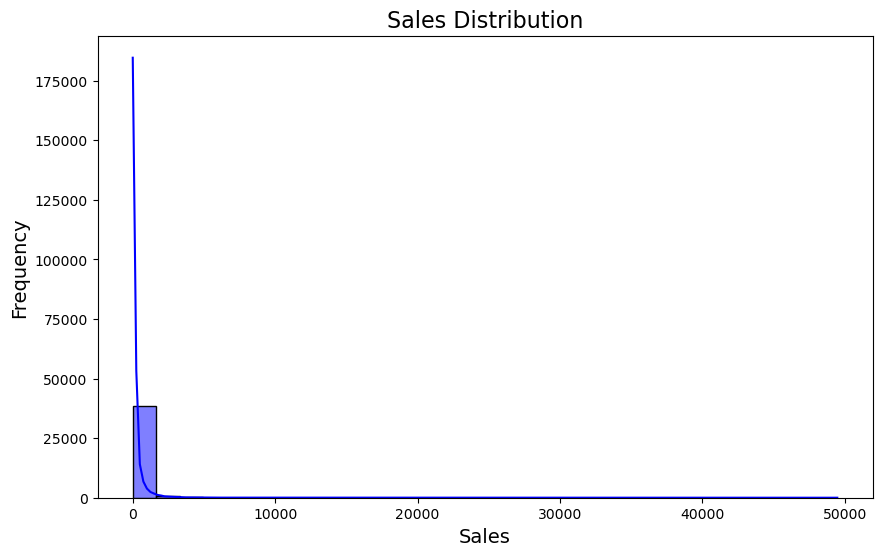

In [7]:
# Visualization: Sales distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_long["Sales"], bins=30, kde=True, color='blue')
plt.title("Sales Distribution", fontsize=16)
plt.xlabel("Sales", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

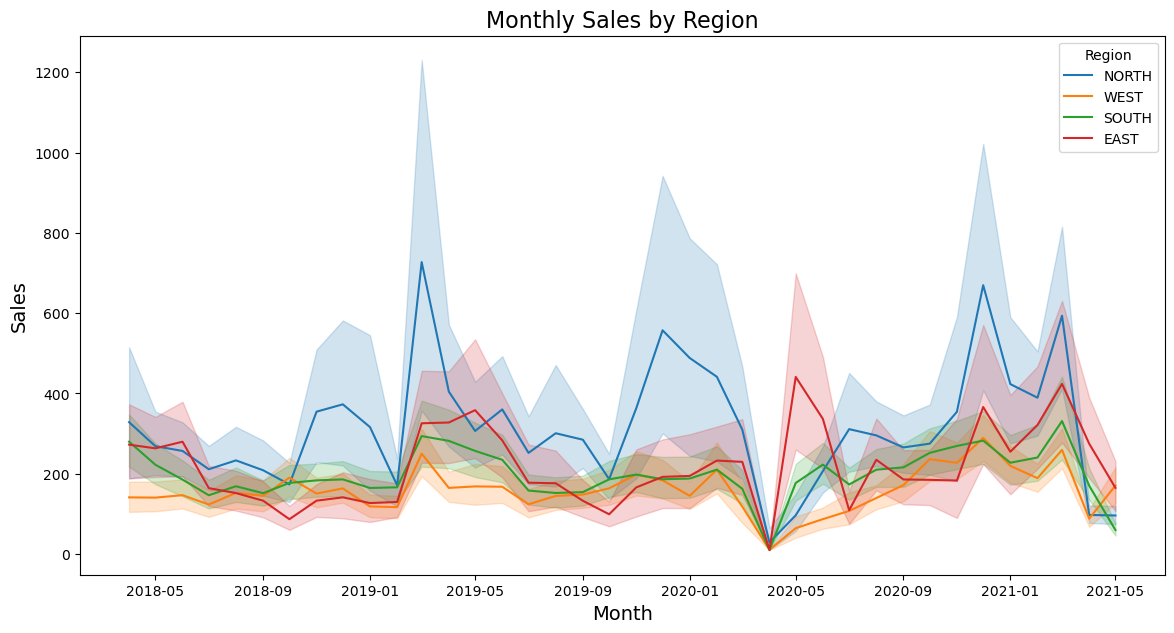

In [8]:
# Visualization: Sales over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=data_long, x="Month", y="Sales", hue="Region", palette="tab10")
plt.title("Monthly Sales by Region", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.legend(title="Region")
plt.show()

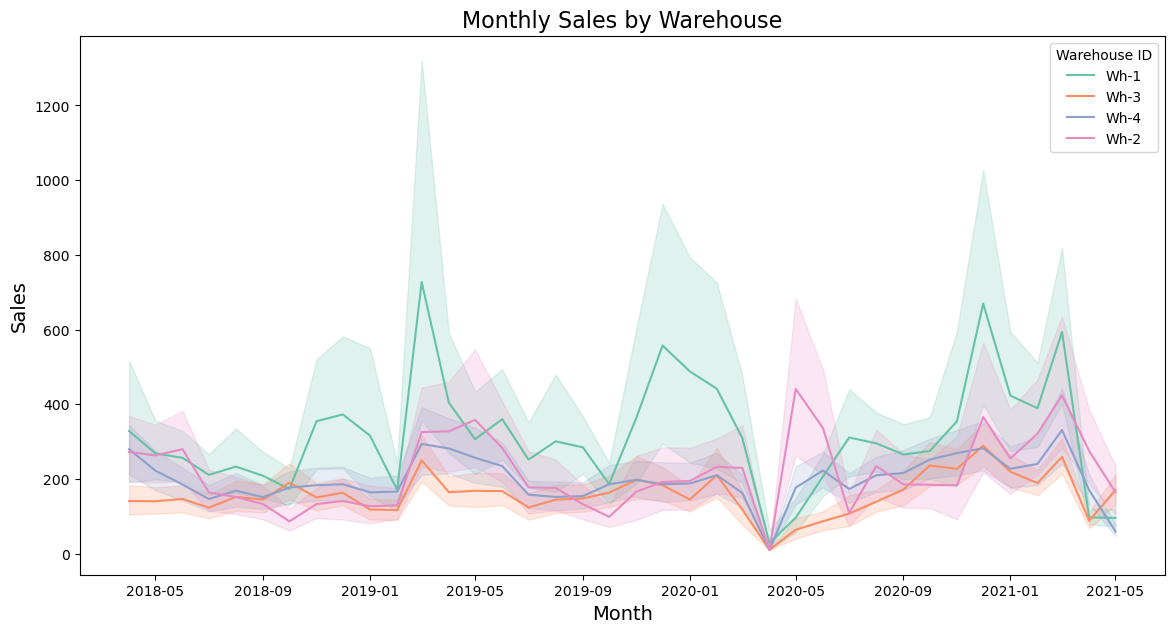

In [9]:
# Visualization: Warehouse-wise sales trends
plt.figure(figsize=(14, 7))
sns.lineplot(data=data_long, x="Month", y="Sales", hue="Warehouse id", palette="Set2")
plt.title("Monthly Sales by Warehouse", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.legend(title="Warehouse ID")
plt.show()


In [10]:
# Function to check stationarity
def is_stationary(series, alpha=0.05):
    """
    Check if a time-series is stationary using the Augmented Dickey-Fuller test.
    Handles constant series gracefully.
    """
    if series.nunique() == 1:
        return True  # Constant series are stationary by definition
    result = adfuller(series.dropna())
    return result[1] < alpha


In [11]:
# Forecasting function
def forecast_sarima(data, sku, warehouse):
    """
    Forecast sales for a specific SKU and warehouse using SARIMA model with fallback logic.
    """
    sku_data = data[(data["SKU id"] == sku) & (data["Warehouse id"] == warehouse)]
    sku_data = sku_data[["Month", "Sales"]].set_index("Month")
    sku_data = sku_data.asfreq('MS')

    if sku_data["Sales"].nunique() == 1:
        return sku_data["Sales"].iloc[0]

    if not is_stationary(sku_data["Sales"]):
        sku_data["Sales_diff"] = sku_data["Sales"].diff().dropna()
        train_data = sku_data["Sales_diff"]
    else:
        train_data = sku_data["Sales"]

    try:
        model = SARIMAX(
            train_data,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        model_fit = model.fit(disp=False)
        forecast = model_fit.get_forecast(steps=1).predicted_mean.values[0]
        if "Sales_diff" in sku_data:
            forecast += sku_data["Sales"].iloc[-1]
        return max(0, forecast)
    except Exception as e:
        print(f"Error forecasting for SKU {sku} and Warehouse {warehouse}: {e}")
        return sku_data["Sales"].mean()


In [12]:
# Generate forecasts for all SKU-Warehouse combinations
forecast_results = []
for _, row in submission_format.iterrows():
    sku = row["SKU id"]
    warehouse = row["Warehouse id"]
    prediction = forecast_sarima(data_long, sku, warehouse)
    forecast_results.append(prediction)

In [25]:

# Add forecasts to the submission format
submission_format1["2021-06-01"] = forecast_results

# Save the results to a CSV file
submission_file_path = "FINAL_submissionn.csv"
submission_format.to_csv(submission_file_path, index=False)

print(f"Forecasting completed. Submission file saved as: {submission_file_path}")


Forecasting completed. Submission file saved as: FINAL_submissionn.csv


In [22]:
print(submission_format.columns)


Index(['Warehouse id', 'Region', 'SKU id', 2021-06-01 00:00:00, '2021-06-01'], dtype='object')
